In [2]:
import numpy as np

with open('../llsp_records.txt', 'rb') as f:
    input_vector_record = np.load(f)
    target_vector_record = np.load(f)
    
target_names=["motor_active_fb","motor_active_side","motor_active_turn","vodometer","b_field_x","b_field_y","b_field_z","gyro_x","gyro_y","gyro_z","accel_x","accel_y","accel_z"]
    
name_index_map={}
for i in range(len(target_names)):
    name_index_map[target_names[i]]=i
    
print("Input vector shape {}".format(input_vector_record.shape))
print("Target vector shape {}".format(target_vector_record.shape))

#clip things.  Fields
for k in [4,5,6]:
    input_vector_record[abs(input_vector_record[:,k])>200,k]=0
    target_vector_record[abs(target_vector_record[:,k])>200,k]=0
    input_vector_record[:,k]=input_vector_record[:,k]/100
    target_vector_record[:,k]=target_vector_record[:,k]/100

#acceleration to 10 m/s/s
for k in [10,11,12]:
    input_vector_record[abs(input_vector_record[:,k])>10,k]=0
    target_vector_record[abs(target_vector_record[:,k])>10,k]=0
    #input_vector_record[:,k]=input_vector_record[:,k]/100
    #target_vector_record[:,k]=target_vector_record[:,k]/100

#vodometer
input_vector_record[:,3]=input_vector_record[:,3]/1000
target_vector_record[:,3]=target_vector_record[:,3]/1000

Input vector shape (184, 17)
Target vector shape (184, 13)


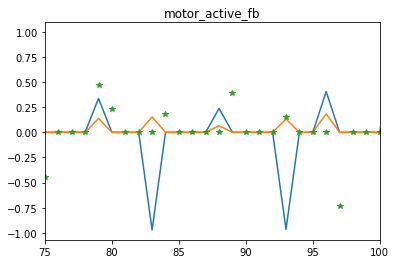

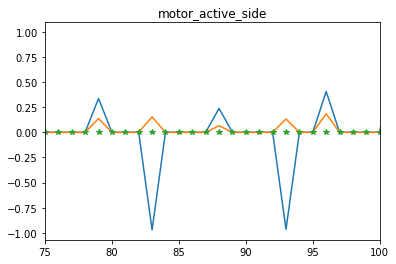

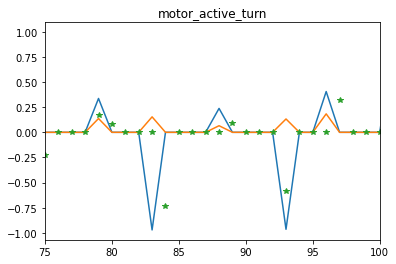

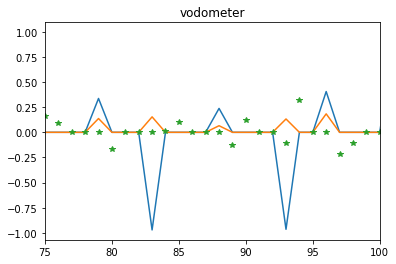

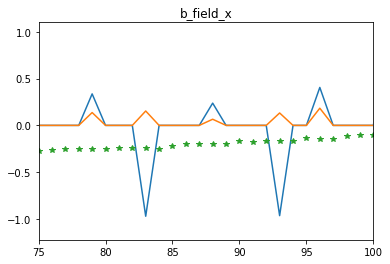

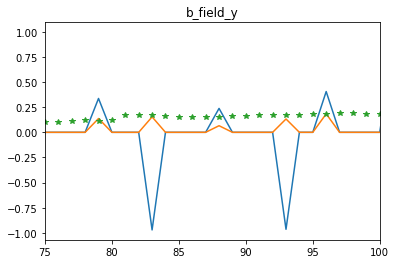

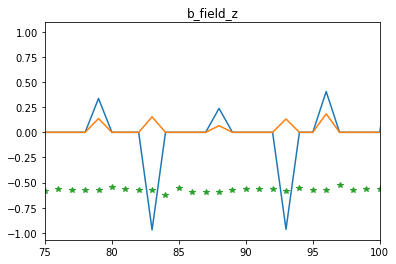

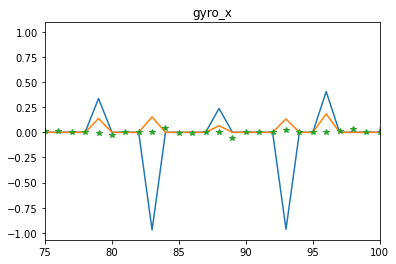

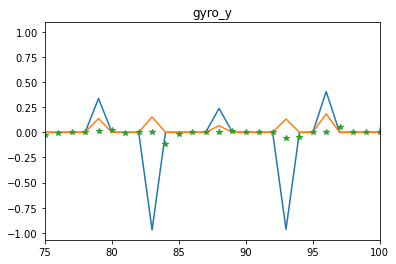

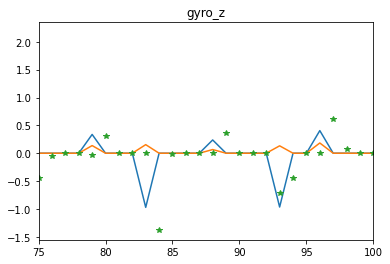

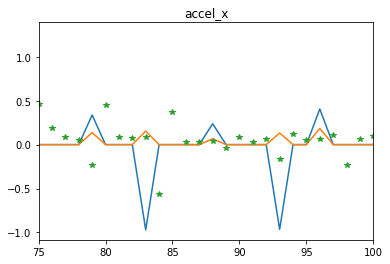

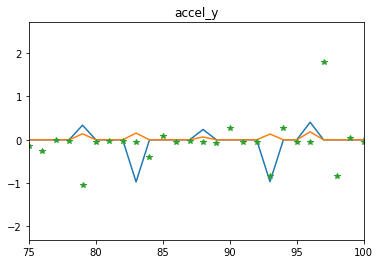

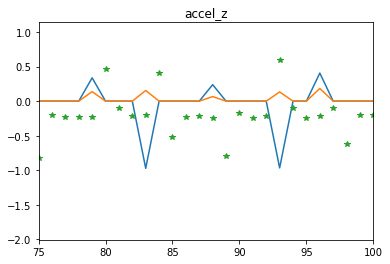

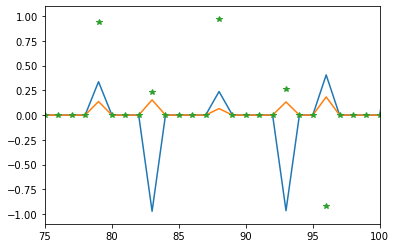

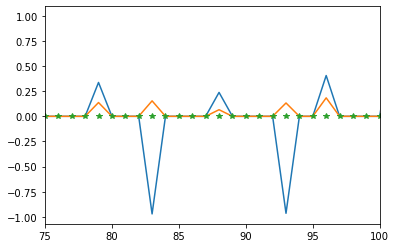

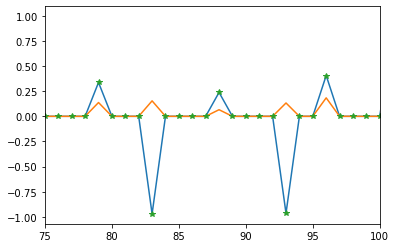

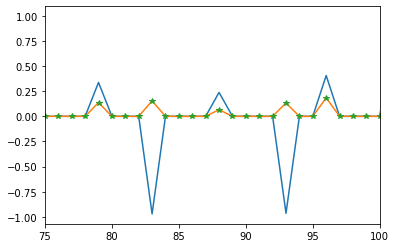

In [9]:
from matplotlib import pyplot as plt

if True:
    for i in range(len(input_vector_record[0])):
        fig, ax = plt.subplots()
        if i<len(target_names):
            plt.title(target_names[i])
        plt.xlim(75,100)
        ax.plot(input_vector_record[:,15])
        ax.plot(input_vector_record[:,16])
        ax.plot(input_vector_record[:,i],'*')
        plt.show()

In [3]:
if False:
    for i in range(len(target_vector_record[0])):
        fig, ax = plt.subplots()
        plt.title(target_names[i])
        ax.plot(target_vector_record[:,i],'*')
        plt.show()

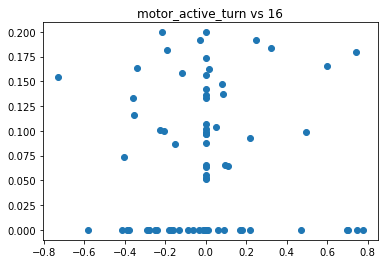

In [39]:
def plot_correlation(name1,name2):
    xs=target_vector_record[:,name_index_map[name1]]
    ys=target_vector_record[:,name_index_map[name2]]
    fig, ax = plt.subplots()
    plt.title("{} vs {}".format(name1,name2))
    ax.scatter(xs,ys)
    plt.show()

def plot_late_correlation(name1,ind):
    xs=target_vector_record[1:,name_index_map[name1]]
    ys=input_vector_record[0:-1,ind]
    fig, ax = plt.subplots()
    plt.title("{} vs {}".format(name1,ind))
    ax.scatter(xs,ys)
    plt.show()
 
plot_late_correlation("motor_active_turn",16)
#plot_correlation("gyro_x","vodometer")
#plot_correlation("gyro_z","motor_active_turn")
#plot_correlation("vodometer","motor_active_turn")
#plot_correlation("accel_z","motor_active_fb")

In [4]:
#scale and normalize
#0-3 are motor active, already normalized
#input_vector_record[:,3]=input_vector_record[:,3]/1000 #pixels per second
#target_vector_record[:,3]=target_vector_record[:,3]/1000 #pixels per second
#magnet x
#input_vector_record[:,4]=(input_vector_record[:,4]-2.7)/100 #magnet x
#input_vector_record[:,5]=(input_vector_record[:,5]-123.6)/100 #magnet y
#input_vector_record[:,6]=(input_vector_record[:,6]+58.58)/100 #magnet z
#target_vector_record[:,4]=(target_vector_record[:,4]-2.7)/100 #magnet x
#target_vector_record[:,5]=(target_vector_record[:,5]-123.6)/100 #magnet y
#target_vector_record[:,6]=(target_vector_record[:,6]+58.58)/100 #magnet z

target_vector_record_shifted=np.zeros(target_vector_record.shape)
for i in range(target_vector_record.shape[0]-1):
    for j in range(target_vector_record.shape[1]):
        target_vector_record_shifted[i,j]=target_vector_record[i+1,j]
        
if False:
    for i in range(len(input_vector_record[0])):
        fig, ax = plt.subplots()
        ax.plot(input_vector_record[:,i],'*')
        plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

#create some training sequences
data_len=input_vector_record.shape[0]
seq_len=20
num_seqs=100

input_seqs=[]
output_seqs=[]
for i in range(num_seqs):
    start_elem=random.randrange(0,data_len-seq_len-1)
    input_seqs.append(torch.from_numpy(input_vector_record[start_elem:start_elem+seq_len]))
    output_seqs.append(torch.from_numpy(target_vector_record[start_elem+1:start_elem+seq_len+1]))    
    
input_seqs=torch.stack(input_seqs).float()
output_seqs=torch.stack(output_seqs).float()

print("input seqs shape {}".format(input_seqs.shape))





#lstm = nn.LSTM(input_vector_record.shape[1], target_vector_record.shape[1],batch_first=True)
#model= nn.RNN(input_vector_record.shape[1], target_vector_record.shape[1],2)

#model=lstm(input_seqs)
#print(test)

input seqs shape torch.Size([100, 20, 17])


In [6]:
class SimpleNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(SimpleNN, self).__init__()
        self.net=nn.Sequential(nn.Linear(input_size,output_size),
                               nn.ReLU(),
                               nn.Linear(output_size,output_size))        
        
    def forward(self,x):
        ret=[]
        #order is trial,seq, 
        for i in range(len(x)):
            ret.append(self.net.forward(x[i]))
        return torch.stack(ret)
    
    #given [t]
    def predict(self,x,n):        
        ret=[]        
        inp=torch.unsqueeze(x,0)
        #print("shape of inp {}".format(inp.shape))
        a=self.net.forward(inp)[0]
        ret.append(a[-1].detach())
        input_vector=torch.zeros(a.shape[-1]+4)
        input_vector[0:a.shape[-1]]=a[-1]
        for i in range(n-1):
            a=self.net.forward(torch.unsqueeze(torch.unsqueeze(input_vector,0),0))[0]            
            ret.append(a[-1].detach())
        return torch.stack(ret)
            
            
        
            
        
    
class MyLSTM(nn.Module):
    def __init__(self,input_size,output_size):
        super(MyLSTM, self).__init__()        
        self.input_size=input_size
        self.output_size=output_size
        self.lstm=nn.LSTM(input_size,input_size,batch_first=True) #number of hidden nodes same as input
        self.combiner=nn.Linear(input_size+input_size,output_size)
        
    def forward(self,x):
        hidden,_=self.lstm(x)
        #print("x shape {}".format(x.shape))
        #print("hidden shape {}".format(hidden.shape))
        merged=torch.cat((x,hidden),2)
        #print("merged shape {}".format(merged.shape))        
        ret=[]
        for i in range(len(x)):
            ret.append(self.combiner(merged[i]))
        return torch.stack(ret)
    
    def single_forward(self,x,hidden):
        #print("x shape {}".format(x.shape))
        #print("hidden shape in {}".format(hidden.shape))
        inp=torch.unsqueeze(torch.unsqueeze(x,0),0)
        hidden,cells=self.lstm(torch.unsqueeze(torch.unsqueeze(x,0),0))
        merged=torch.cat((inp,hidden),2)
        a=self.combiner(merged)
        #print("a shape {}".format(a.shape))
        #print("hidden shape {}".format(hidden.shape))
        return a[0][0],hidden[0][0]
        
            
    def predict(self,x,n):
        hidden=torch.zeros(self.lstm.hidden_size)
        vals=torch.zeros(self.input_size)
        for i in range(len(x)-1):
            vals,hidden=self.single_forward(x[i],hidden)
        ret=[]
        ret.append(vals.detach())
        input_vector=torch.zeros(self.input_size)        
        for i in range(n-1):            
            input_vector[0:self.output_size]=vals
            vals,hidden=self.single_forward(input_vector,hidden)
            ret.append(vals.detach())
        return torch.stack(ret)
            

    

In [7]:
simplemodel=SimpleNN(input_vector_record.shape[1],target_vector_record.shape[1])

lstmmodel=MyLSTM(input_vector_record.shape[1],target_vector_record.shape[1])

ret=lstmmodel(input_seqs)
print(ret.shape)

torch.Size([100, 20, 13])


In [8]:
from tqdm import tqdm

def train_simple():
    optimizer = optim.Adam(simplemodel.parameters(), lr=0.001)
    loss_function = torch.nn.MSELoss()
    loss_record=[]
    
    for epoch in tqdm(range(2000)):
    #for epoch in tqdm(range(20)):
        out=simplemodel(input_seqs)
        loss=loss_function(out,output_seqs)
        loss_record.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss_record
    
def train_lstm():
    optimizer = optim.Adam(lstmmodel.parameters(), lr=0.001)
    loss_function = torch.nn.MSELoss()
    loss_record=[]
    for epoch in tqdm(range(2000)):
    #for epoch in tqdm(range(10)):
        out=lstmmodel(input_seqs)
        loss=loss_function(out,output_seqs)
        loss_record.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_record
    
model=lstmmodel
lstm_loss_record=train_lstm()
simple_loss_record=train_simple()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 84.97it/s]


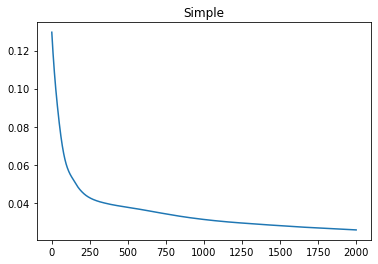

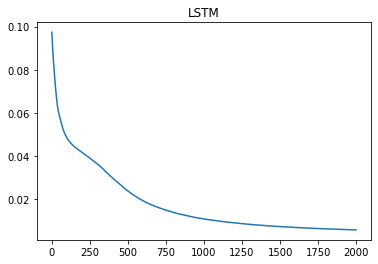

best simple loss 0.025788240134716034
best lstm loss 0.005736253689974546


In [9]:
fig, ax = plt.subplots()
plt.title("Simple")
ax.plot(simple_loss_record)
plt.show()

fig, ax = plt.subplots()
plt.title("LSTM")
ax.plot(lstm_loss_record)
plt.show()

print("best simple loss {}".format(simple_loss_record[-1]))
print("best lstm loss {}".format(lstm_loss_record[-1]))

In [10]:
all_input=torch.stack([torch.from_numpy(input_vector_record).float()])

def test_model_on_all(model):
    my_out=model(all_input)
    summersq=0
    for i in range(len(target_vector_record)):
        for j in range(len(target_vector_record[0])):
            #summersq+=(target_vector_record[i+1][j]-my_out[0][i][j])**2
            summersq+=(target_vector_record_shifted[i][j]-my_out[0][i][j])**2
    return summersq
    

def plot_test(model,title):    
    my_out=model(all_input)            
    for i in range(len(target_vector_record_shifted[0])):        
        fig, ax = plt.subplots()
        plt.title("{} - {}".format(title,target_names[i]))
        #plt.xlim(100,140)
        ax.plot(target_vector_record_shifted[:,i])
        #ax.plot(target_vector_record[:,i])

        ax.plot(my_out[0,:,i].detach().numpy(),'*')
        
        plt.show()

print("simple model {}".format(test_model_on_all(simplemodel)))
print("lstm model {}".format(test_model_on_all(lstmmodel)))

#plot_test(simplemodel,"simple")
#plot_test(lstmmodel,"lstm")

simple model 63.20573043823242
lstm model 9.499682426452637


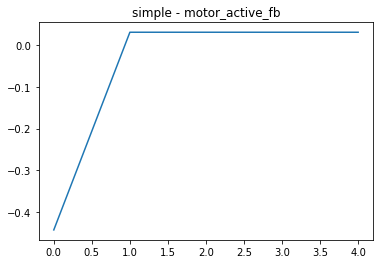

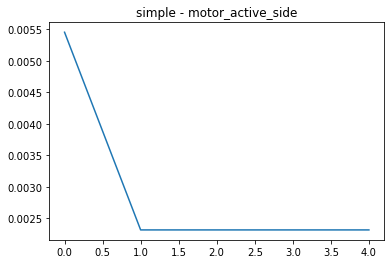

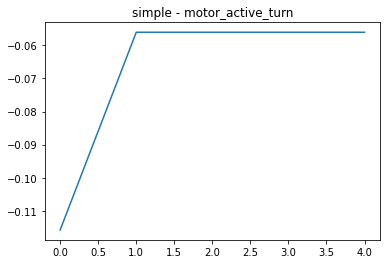

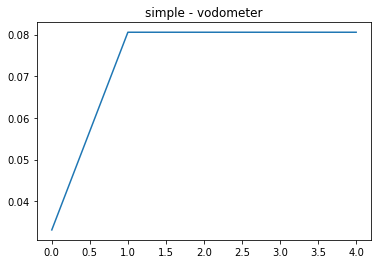

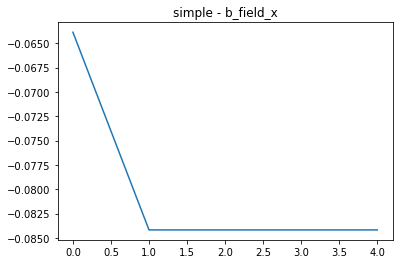

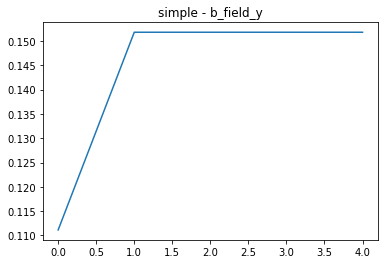

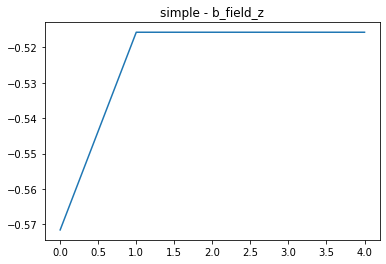

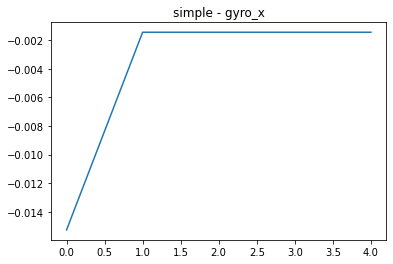

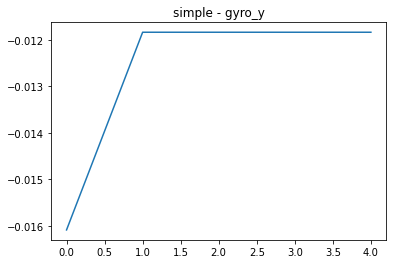

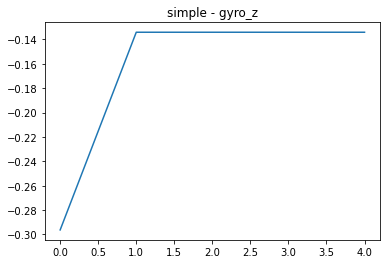

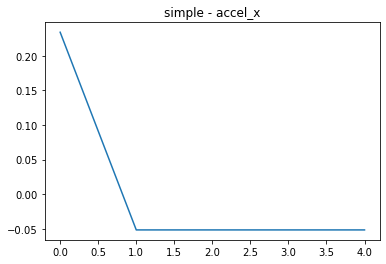

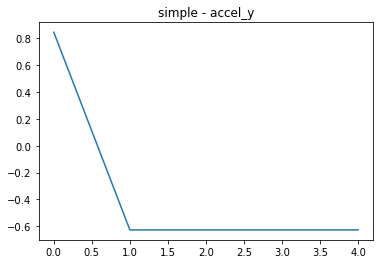

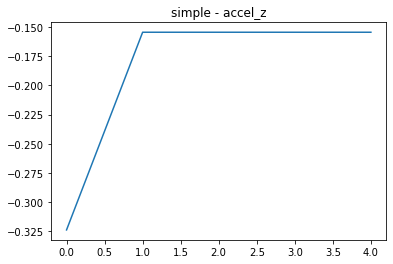

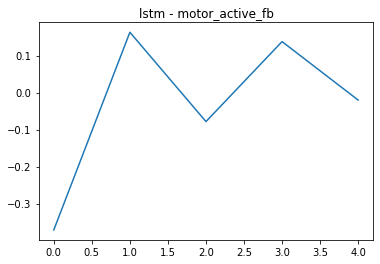

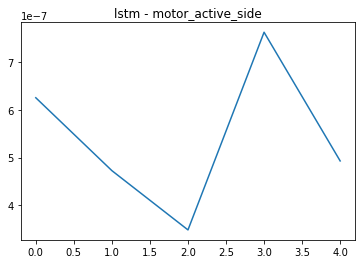

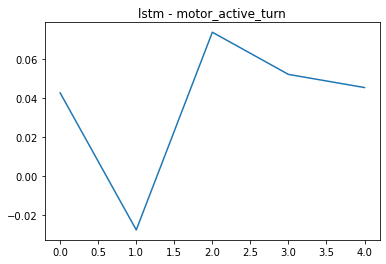

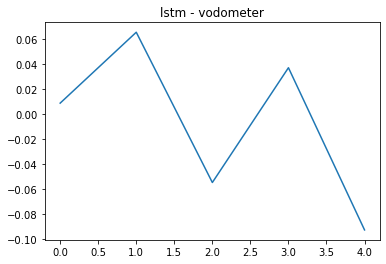

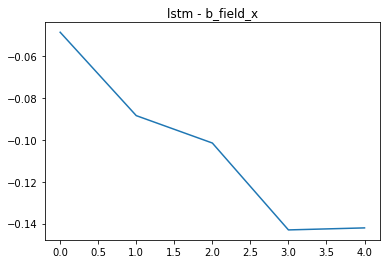

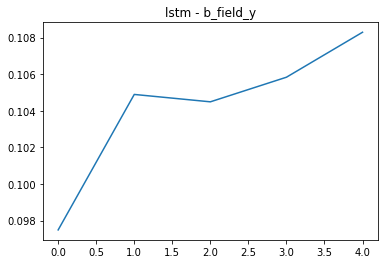

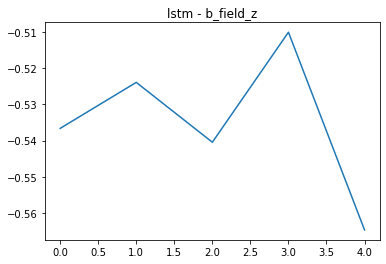

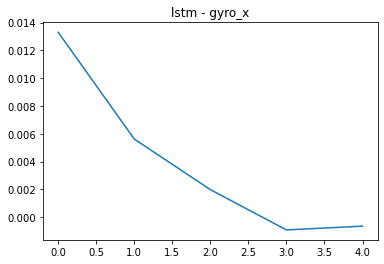

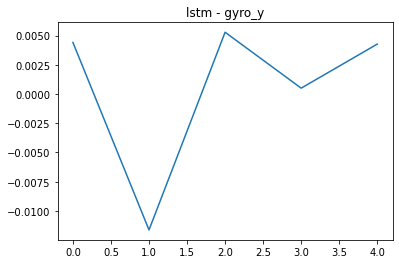

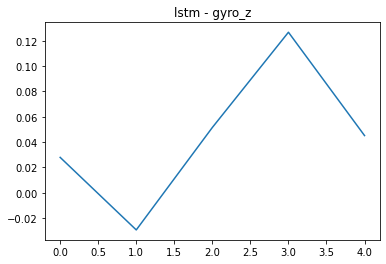

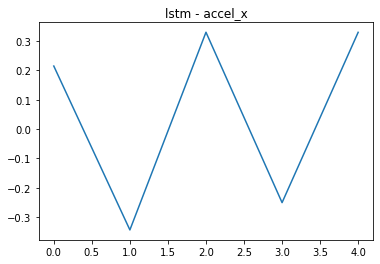

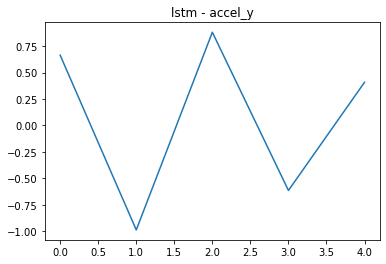

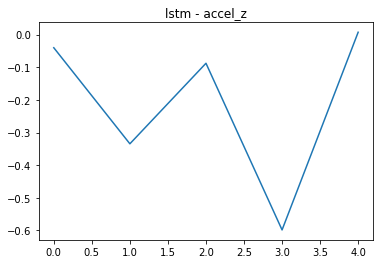

In [14]:
#lets see what a turn or a f/b will look like
#target_names=["motor_active_fb","motor_active_side","motor_active_turn","vodometer","b_field_x","b_field_y","b_field_z","gyro_x","gyro_y","gyro_z","accel_x","accel_y","accel_z"]


def plot_test(model,title):    
    input_default=[0,0,0,0,0,0.1,-0.6,0,0,0,0,0,-0.2,0,0,0,0]

    test_vector=[]
    for i in range(4):
        test_vector.append(input_default)
    test_vector[-1][-4]=-0.6
    test_vector[-1][-1]=0.1

    #print(test_vector)    
    r=model.predict(torch.from_numpy(np.array(test_vector)).float(),5)    
    
    #print(r.shape)
    #my_out=model(all_input)            
    for i in range(len(r[0])):        
        fig, ax = plt.subplots()
        plt.title("{} - {}".format(title,target_names[i]))
        #plt.xlim(100,140)
        ax.plot(r[:,i])
        #ax.plot(target_vector_record[:,i])
        #ax.plot(my_out[0,:,i].detach().numpy(),'*')
        
        plt.show()

plot_test(simplemodel,"simple")
plot_test(lstmmodel,"lstm")
